# Car Object Detection

**Описание:** На входе у нас покадровый видеопоток с возможностью работать в режиме реального времени, с тактовой частотой 45 кадров в секунду. Необходимо использовать Fast YOLO, который обрабатывает поток со скоростью 155 кадров в секунду.  

**Задача:** Набор данных содержит покадровый видеопоток передвижения автомобилей во всех представлениях, ваша задача создать алгоритм для их обнаружения.  

**Датасет:** https://www.kaggle.com/sshikamaru/car-object-detection

## Библиотеки и скрипты

In [1]:
import numpy as np
import pandas as pd
import cv2, time

from pathlib import Path
import tensorflow.keras
from keras.preprocessing import image
from keras.optimizers import Adam
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, 
                          Conv2D, Conv2DTranspose, concatenate)

import keras
from IPython.display import clear_output

import tensorflow
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

In [2]:
# Проверяем, что GPU подключен
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Загрузка и обзор данных

In [3]:
# Загружаем данные
df_train = list(Path('./data/car_detection/train/').iterdir())
df_test = list(Path('./data/car_detection/test/').iterdir())

In [4]:
# path_train = './data/car_detection/train/'
# path_validation = './data/car_detection/test/'

# train_images_paths = list(Path(df_train).iterdir())
# validation_images_paths = list(Path(df_test).iterdir())

In [5]:
# Устанавливаем размер изображения
# single_image = image.load_img(df_train[0])
# image_size = (int(single_image.size[0]/2), single_image.size[1])
# image_size

In [6]:
# Устанавливаем размер изображения
image_size = (256, 256)
image_size

(256, 256)

In [7]:
# Добавляем все кадры из df_train в массив
def load_images_with_masks(paths):
    images = []
    masks = []

    for path in df_train:
        temp_img = image.load_img(path) 
        img = temp_img.crop((0, 0, image_size[0], image_size[1])) 
        mask = temp_img.crop((image_size[0], 0, image_size[0] * 2, image_size[1]))
        images.append(img)
        masks.append(mask)

    return images, masks

images, masks = load_images_with_masks(df_train)

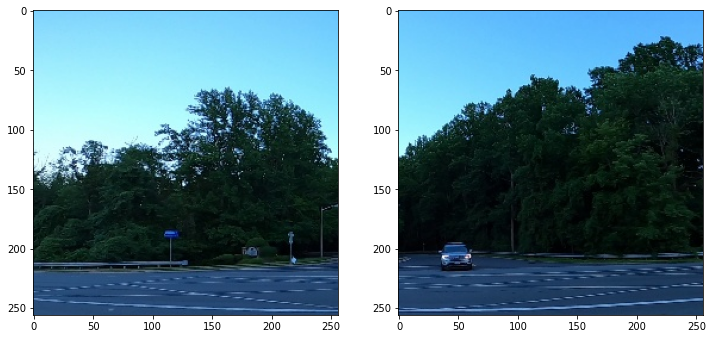

In [8]:
# Смотрим пример данных
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(images[0].convert('RGBA'))
ax[1].imshow(masks[0].convert('RGBA'))

## Предобработка данных

**Создаём обучающую выборку**

In [9]:
def get_X_images(images):
    X = []

    for img in images[:170]:
      x = image.img_to_array(img)
      X.append(x)

    X = np.array(X)
    return X

In [10]:
X = get_X_images(images)

In [11]:
print(X.shape)

(170, 256, 256, 3)


In [12]:
def extract_classes_masks(masks, gradations_number=3):
    classes = set()
    max_color_value = 255
    color_group_divider = int(max_color_value / gradations_number) 

    for mask in masks:
        for pixel in masks[0].convert('RGBA').getdata():
            r = int(pixel[0] / color_group_divider) * color_group_divider
            g = int(pixel[1] / color_group_divider) * color_group_divider
            b = int(pixel[2] / color_group_divider) * color_group_divider
            classes.add((r, g, b,))

    return [[item[0], item[1], item[2]] for item in list(classes)]

In [13]:
classes = extract_classes_masks(masks, 3)
classes

[[0, 0, 85],
 [0, 85, 85],
 [170, 255, 255],
 [0, 85, 0],
 [85, 170, 255],
 [85, 0, 85],
 [255, 170, 255],
 [85, 170, 170],
 [0, 170, 170],
 [170, 255, 170],
 [0, 0, 0],
 [170, 170, 170],
 [0, 85, 170],
 [170, 170, 255],
 [85, 85, 85],
 [85, 85, 170]]

In [14]:
# Делаем конвертер в one-hot_encoding для выходных примеров
def Color2index(y, classes):
    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(classes)))
    i = 1
    for color in classes:
        ind_i = np.where(
            (y[..., 0] >= color[0]) & (y[..., 0] <= color[0] + 85) 
            & (y[..., 1] >= color[1]) & (y[..., 1] <= color[1] + 85)
            & (y[..., 2] >= color[2]) & (y[..., 2] <= color[2] + 85)
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1 
        i += 1
    
    return y_cat, y_ind

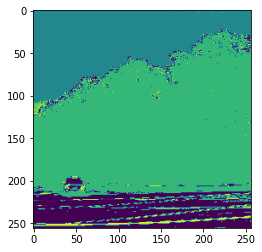

In [15]:
cat_yi, ind_yi = Color2index(image.img_to_array(masks[0]), classes)
plt.imshow(ind_yi)
plt.show() 

In [16]:
ind_yi

array([[ 8.,  8.,  8., ...,  8.,  8.,  8.],
       [ 8.,  8.,  8., ...,  8.,  8.,  8.],
       [ 8.,  8.,  8., ...,  8.,  8.,  8.],
       ...,
       [11., 11., 11., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

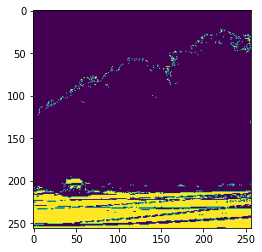

In [17]:
plt.imshow(cat_yi[..., 0])
plt.show()

In [18]:
cat_yi.shape

(256, 256, 16)

In [19]:
# Сегментированную картинку в One hot encoding
def get_target_masks(masks):
    y = []

    for mask in masks[:170]:
        y_cat, _ = Color2index(image.img_to_array(mask), classes)
        y.append(y_cat)

    y = np.array(y)
    return y

In [20]:
y = get_target_masks(masks)

In [21]:
print(y.shape)

(170, 256, 256, 16)


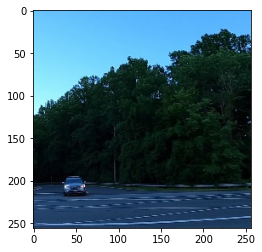

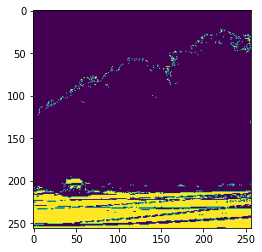

In [22]:
n = 0
plt.imshow(masks[n].convert('RGBA'))
plt.show()
img = y[n][..., 0]

plt.imshow(img)
plt.show()

## Обучение нейросети

### Делим датасет на трейн и тест по числу N

In [23]:
X.shape, y.shape

((170, 256, 256, 3), (170, 256, 256, 16))

In [24]:
N = 85
y_train = y[:N, ...]
X_train = X[:N, ...]

y_test = y[N:, ...]
X_test = X[N:, ...]

In [25]:
print(X_train.shape)
print(y_train.shape)

(85, 256, 256, 3)
(85, 256, 256, 16)


In [26]:
print(X_test.shape)
print(y_test.shape)

(85, 256, 256, 3)
(85, 256, 256, 16)


### Создаём и обучаем U-net

In [27]:
def Unet(num_classes=16, input_shape=(256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)


    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)


    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

 
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

In [28]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [29]:
model = Unet()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [30]:
print(X_test.shape)
print(y_test.shape)

(85, 256, 256, 3)
(85, 256, 256, 16)


### Custom Callback

In [98]:
sample_image = X_test[77]
sample_mask = y_test[77]

In [99]:
def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 0]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image / 255.0)
    ax[1].imshow(sample_mask[..., 0])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()


class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_predictions(self.model)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

(1, 256, 256)


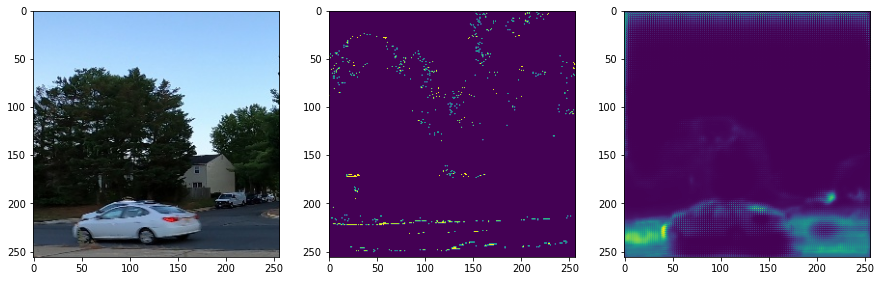

In [100]:
show_predictions(model)

(1, 256, 256)


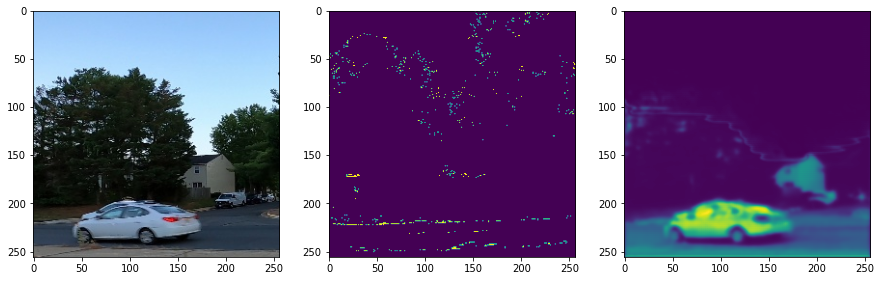


Sample Prediction after epoch 15


In [101]:
# Делаем предсказание
history = model.fit(X_train, y_train,
                      epochs=15,
                      batch_size=1,
                      validation_data=(X_test, y_test),
                      callbacks=[DisplayCallback(patience=5)])

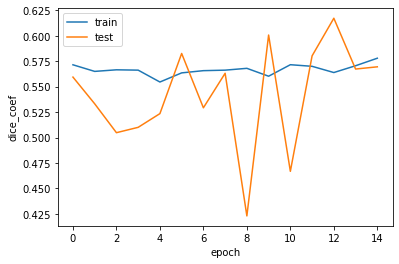

In [102]:
# Коэффициент DICE
plt.plot(history.history['dice_coef'], label='train')
plt.plot(history.history['val_dice_coef'], label='test')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

## Валидация модели

### Проверяем результат на валидационной выборке

In [103]:
val_images, val_masks = load_images_with_masks(df_test)

In [104]:
X_val = get_X_images(val_images)

In [105]:
y_val = get_target_masks(val_masks)

In [106]:
pred = model.predict(X_val[:50])
print(pred.shape)

(50, 256, 256, 16)


In [ ]:
# pred = model.predict(X_val)
# print(pred.shape)

### Визуализируем данные

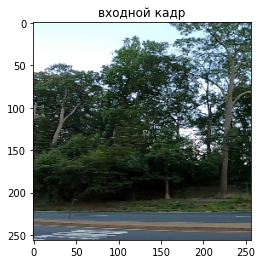

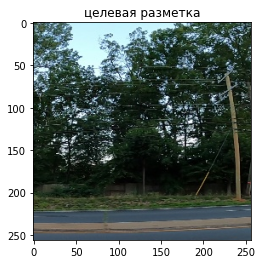

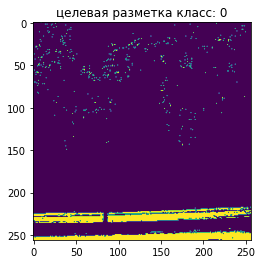

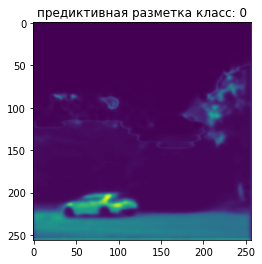

In [152]:
n = 4
class_ = 0

plt.imshow(images[N + n].convert('RGBA'))
plt.title('входной кадр')
plt.show()

plt.imshow(masks[N + n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()

img = y_test[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()

img = pred[n][..., class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: ' + str(class_))
plt.show()

### Делаем выводы

**Вывод**: алгоритм неплохо научился распознавать движущиеся по дороге автомобили.

**Планы** можно также взять предобученный backbone для сети, чтобы алгоритм извлечения признаков из изображений уже был обучен.  
Для этого потребуется все картинки прогнать через препроцессинг для модели, которую возьмем как backbone.